## PUI 2016 HOMEWORK 11, ASSIGNMENT 2
#### Ian Wright, iw453
#### November 2016

In [310]:
# standard imports
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('ggplot')

import zipfile

# geo-imports
import geopandas as gpd
from fiona.crs import from_epsg
import shapely
import pysal as ps

# cluster analysis
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist

# env variables
PUIdata = os.getenv('PUIDATA')
print 'PUIdata:', PUIdata

PUIdata: /Users/ian/school/hw/PUI2016/PUIDATA


### !!! Don't run the following cell if the census data for business data has already been downloaded to PUIDATA !!!

In [14]:
# download the business census data from 1994 - 2001 to PUIDATA
#!for ((y=94; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip -P $PUIDATA; done
#!for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip -P $PUIDATA; done

# download the business census data from 2002 - 2014 to PUIDATA
#!for ((y=2; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip -P $PUIDATA; done
#!for ((y=10; y<=14; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip -P $PUIDATA; done

--2016-11-27 21:29:18--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip
           => ‘/Users/ian/school/hw/PUI2016/PUIDATA/zbp94totals.zip’
Resolving ftp.census.gov... 2610:20:2010:a09:1000::9481:4b23, 148.129.75.35
Connecting to ftp.census.gov|2610:20:2010:a09:1000::9481:4b23|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp94totals.zip ... 611524
==> EPSV ... done.    ==> RETR zbp94totals.zip ... done.
Length: 611524 (597K) (unauthoritative)

zbp94totals.zip     100%[===================>] 597.19K  1.20MB/s    in 0.5s    

2016-11-27 21:29:21 (1.20 MB/s) - ‘/Users/ian/school/hw/PUI2016/PUIDATA/zbp94totals.zip’ saved [611524]

--2016-11-27 21:29:21--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp95totals.zip
           => ‘/Users/ian/school/hw/PUI2016/PUIDATA/zbp95totals.zip’
Resolving ftp.census.gov... 2610:20:2010:a09:1000::

### Loading census data

In [130]:
# unzip and read text files as dataframes into notebook
census_years = {}

# 1994 - 1999
for year in range(94, 100):
    file_path = PUIdata + '/zbp{}totals.zip'.format(str(year))
    just_file = 'zbp{}totals.zip'.format(str(year))
    zf = zipfile.ZipFile(file_path)
    census_years['19' + str(year)] = pd.read_csv(zf.open(just_file.replace('.zip','.txt')))
    
# 2000 - 2009
for year in range(0, 10):
    file_path = PUIdata + '/zbp0{}totals.zip'.format(str(year))
    just_file = 'zbp0{}totals.zip'.format(str(year))
    zf = zipfile.ZipFile(file_path)
    census_years['200' + str(year)] = pd.read_csv(zf.open(just_file.replace('.zip','.txt')))

# 2010 - 2014
for year in range(10, 15):
    file_path = PUIdata + '/zbp{}totals.zip'.format(str(year))
    just_file = 'zbp{}totals.zip'.format(str(year))
    zf = zipfile.ZipFile(file_path)
    census_years['20' + str(year)] = pd.read_csv(zf.open(just_file.replace('.zip','.txt')))

### Cleaning and reshaping census data

In [131]:
# reduce each census dataset down to just zip code and number of establishments ('est')
for year, data in census_years.iteritems():
    if 'zip' in data.columns:
        if 'est' in data.columns:
            census_years[year] = data.loc[:,['zip', 'est']]
        else:
            census_years[year] = data.loc[:,['zip', 'EST']]
    else:
        if 'est' in data.columns:
            census_years[year] = data.loc[:,['ZIP', 'est']]
        else:
            census_years[year] = data.loc[:,['ZIP', 'EST']]
    
    # standardize column names
    census_years[year].columns = ['zip', year]

In [259]:
# merge each year's data by zip code, in chronological order, into a single dataframe
# start with 1994 as basis
all_time = census_years['1994']
for year in sorted(census_years):
    if year == '1994':
        pass
    else:
        # by doing an inner join, we only preserve the complete time series
        all_time = all_time.merge(census_years[year], how='inner', on='zip')

# use zip as index
all_time = all_time.set_index('zip')
all_time.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
1001,439,439,433,457,444,469,493,490,490,505,...,509,509,503,477,458,448,436,453,439,458
1002,450,467,487,500,490,558,563,587,566,586,...,589,582,596,584,571,570,558,572,572,560
1003,10,10,13,15,14,13,13,13,15,16,...,12,12,16,17,16,16,16,15,15,18
1004,47,48,47,41,31,35,48,37,23,21,...,31,30,20,18,18,21,19,16,16,13
1005,92,95,101,104,95,82,86,90,94,93,...,94,98,106,97,87,96,91,94,97,97


### Loading NYC zip shape data

In [115]:
# the zip code geo file has already been placed in the PUIdata directory
shape_path = PUIdata + '/nyc-zip-code-tabulation-areas-polygons.geojson'
nyc_shapes = gpd.GeoDataFrame.from_file(shape_path)
nyc_shapes.crs = from_epsg(4326)
nyc_shapes.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [260]:
# trim our 'all_time' dataset to only those zip codes in NYC
nyc_zips = nyc_shapes.postalCode.unique()
nyc_zips = map(int, nyc_zips)

all_time = all_time[all_time.index.isin(nyc_zips)]
print len(all_time), 'zip codes in census data'
print 'shape:', all_time.shape

230 zip codes in census data
shape: (230, 21)


### Standardize the time series

In [261]:
# subtract the mean and divide by standard deviation for each time series
for zipcode, series in all_time.iterrows():
    
    std = np.std(series)
    mean = np.mean(series)
    
    all_time.loc[zipcode] = series.map(lambda est: (est - mean) / std) 

all_time.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.884610,-1.222765,-1.319439,-0.731959,0.011686,-0.144480,0.480182,-0.479120,-0.828633,-1.252511,...,0.443000,1.208955,2.205439,1.632833,0.390945,-0.084988,-0.189098,-0.129607,0.152978,0.866878
10002,-1.755856,-1.666569,-1.411464,-1.079826,-1.197175,-0.987988,-0.498185,0.180396,-0.518594,-0.179303,...,0.534993,0.545197,0.542646,0.557953,0.772242,1.019694,1.121736,1.228881,1.315617,1.274800
10003,-1.865454,-1.470082,-1.339380,-0.953811,-0.581311,-0.548636,-0.470215,-0.734885,-0.689140,-0.401596,...,0.131013,0.268250,0.725705,0.797591,0.889082,0.934828,1.085135,1.264849,1.470704,1.653687
10004,-1.550004,-1.473734,-1.397465,-1.058490,-1.033067,-0.550027,-0.033090,-0.431386,-0.380540,-0.389014,...,-0.321219,0.110974,0.610962,0.661808,0.687232,0.848245,0.899091,1.221117,1.534669,2.170247
10005,-2.888971,-2.319881,-0.474652,-0.284955,0.456585,-0.026278,0.749753,0.094438,0.008212,-0.750574,...,-0.509142,0.266889,0.508321,0.818733,0.525566,0.387605,0.991185,0.508321,0.904959,1.336087


### K-Means clustering analysis

In [262]:
# define a function that helps us to choose optimal k
def elbow(data, K):
    """
    This function was provided in an applied data science class lab.
    It takes two arguments: 
        - a dataset for clustering (data)
        - a list of integers for which we want to test as k in k-means clustering
    For each value of k, the function calculates the average minimum distance from 
    each data point to it's nearest cluster.
    Then, an elbow chart is plotted and we can use visual inspection to decide which
    value of k makes the most sense... this is where the 'elbow' exists.
    """
    # create a kmeans model for each value of k
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # save the set of centroid locations for each value of k (each kmeans model)
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between every datapoint and each centroid 
    D_k = [cdist(data, cent, 'euclidean')**2 for cent in centroids]

    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    distances = [np.min(D, axis=1) for D in D_k]
    
    # Calculate the Average SSE
    avgWithinSS = [sum(d) / data.shape[0] for d in distances]
    
    # now plot an elbow curve
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow chart for k-means clustering on census time series')
    plt.show()

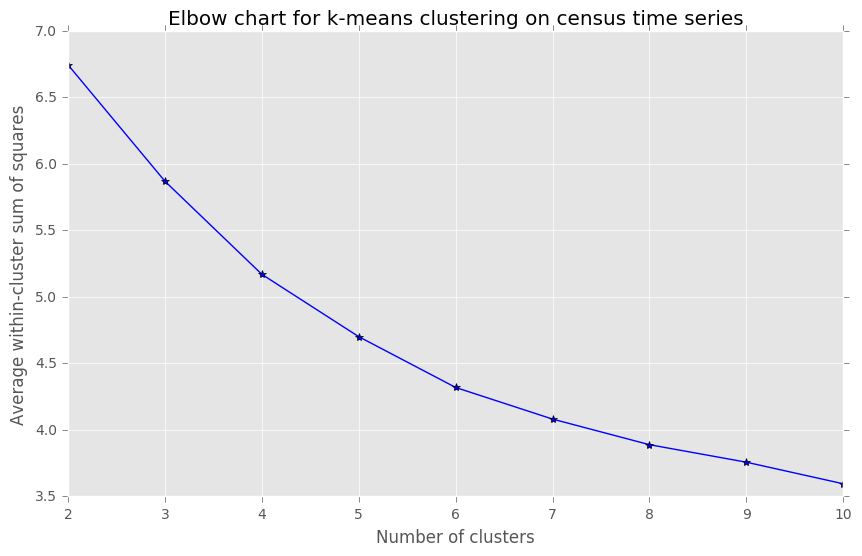

In [263]:
# look at SSE values for k 2 through 10
elbow(all_time, np.arange(2, 11, 1))

##### Figure 1: The intent of an elbow chart is to find the most drastic inflection point where it looks like the marginal reduction in SSE is negligible. There is no clear elbow for this dataset, but we do see that k=6 has a reasonable sharp inflection, so we can select k=6 for further clustering analysis on the time series.

In [264]:
# k-means clustering with k=6
km = KMeans(n_clusters=6, random_state=100)
all_time['label'] = km.fit_predict(all_time)

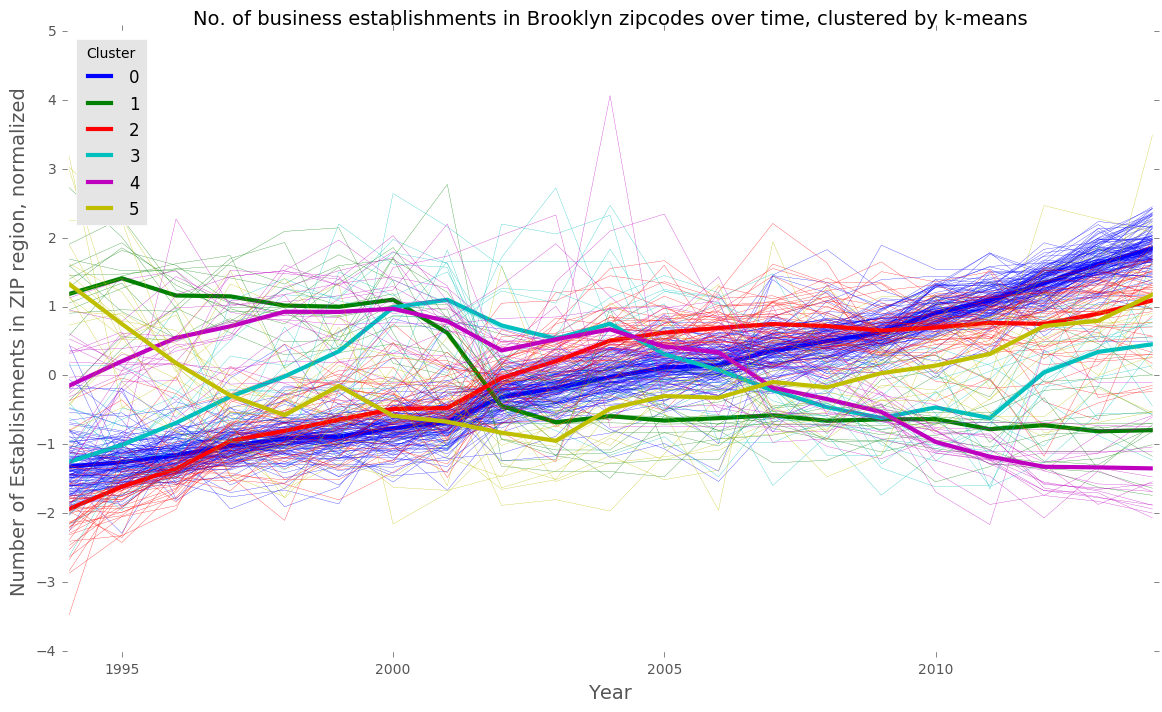

In [268]:
# PLOTTING K-MEANS CLUSTERS OVER TIME
# create a list of matplotlib colors of length k to corresond to each cluster
colors = ['b', 'g', 'r', 'c', 'm', 'y']
cluster_info = zip(km.cluster_centers_, set(km.labels_), colors)

f, ax = plt.subplots(figsize=(14, 8))

for cluster in cluster_info:
    
    # isolate the zip codes that belong to a given cluster
    to_plot = all_time[all_time['label'] == cluster[1]].iloc[:, :-1]
    # plot all zip codes in each cluster, as same color
    ax.plot(to_plot.T, c=cluster[2], lw=.2)
    # plot cluster center
    ax.plot(all_time.T.index[:-1], cluster[0], c=cluster[2], lw=3, label=cluster[1])

ax.set_xlim(1994, 2014)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Number of Establishments in ZIP region, normalized', fontsize=14)
ax.set_axis_bgcolor('white')
ax.set_title('No. of business establishments in Brooklyn zipcodes over time, clustered by k-means', fontsize=14)
ax.legend(loc='upper left', title='Cluster')
plt.show()

##### Figure 2: Brooklyn zip codes are clustered by k-means into 6 distinct clusters, based on the dynamics of a count of business establishments within the areas over time. Cluster centers (equivalent to averages for the k-means method), are shown as bold lines in the same cluster colors.

### Try a different clustering technique (agglomerative)

In [273]:
# "Recursively merges the pair of clusters that minimally increases a given linkage distance."
# assumes 'ward' linkage; minimizes the variance of clusters being linked together in each iteration
# use same k=6
ag = AgglomerativeClustering(n_clusters=6)
all_time['label2'] = ag.fit_predict(all_time)

/Users/ian/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


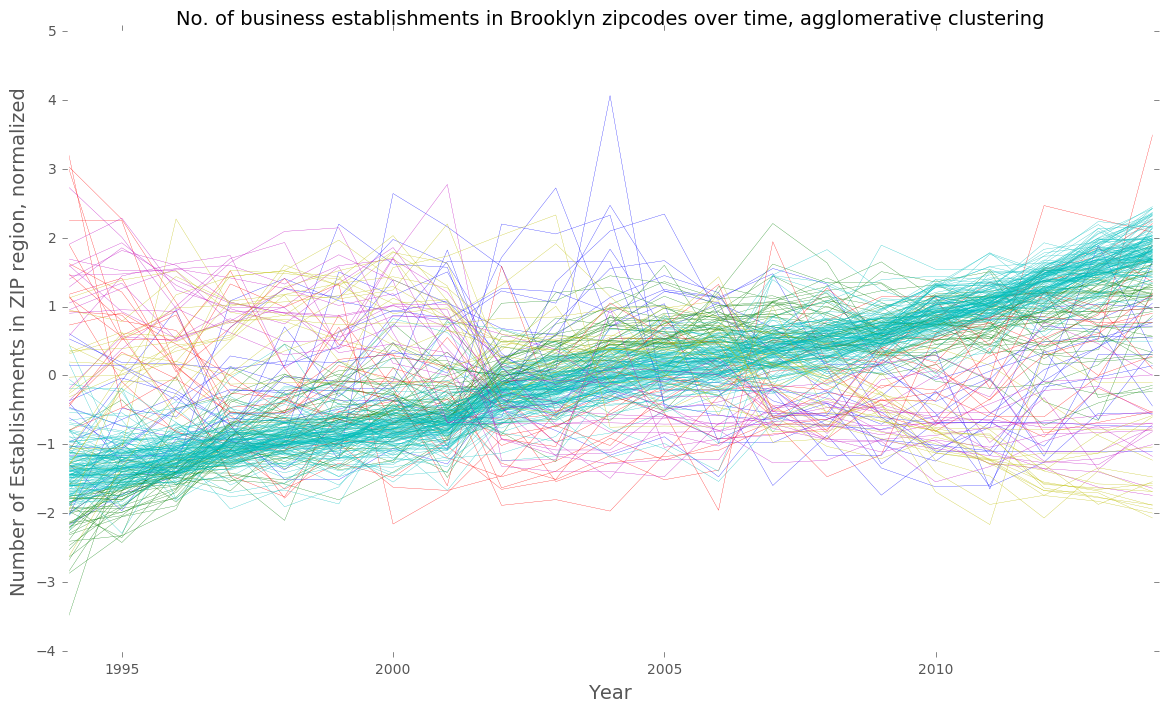

In [277]:
# PLOTTING K-MEANS CLUSTERS OVER TIME (NO CLUSTER CENTERS FOR THIS METHOD)
# create a list of matplotlib colors of length k to corresond to each cluster
colors = ['b', 'g', 'r', 'c', 'm', 'y']
cluster_info = zip(set(ag.labels_), colors)

f, ax = plt.subplots(figsize=(14, 8))

for cluster in cluster_info:
    
    # isolate the zip codes that belong to a given cluster
    to_plot = all_time[all_time['label2'] == cluster[0]].iloc[:, :-2]
    # plot all zip codes in each cluster, as same color
    ax.plot(to_plot.T, c=cluster[1], lw=.2)

ax.set_xlim(1994, 2014)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Number of Establishments in ZIP region, normalized', fontsize=14)
ax.set_axis_bgcolor('white')
ax.set_title('No. of business establishments in Brooklyn zipcodes over time, agglomerative clustering', fontsize=14)
ax.legend(loc='upper left', title='Cluster')
plt.show()

##### Figure 3: Brooklyn zip codes are clustered by k-means into 6 distinct clusters, based on the dynamics of a count of business establishments within the areas over time. As compared to Figure 2 (k-means), Figure 3 shows the results of an agglomerative clustering technique.

### Comparing clustering methods

In [303]:
# how large are the resultant clusters from each clustering method?
print 'k-means cluster sizes:', all_time.groupby('label').count()['2014']
print 'agglomerative cluster sizes:', all_time.groupby('label2').count()['2014']

k-means cluster sizes: label
0    123
1     14
2     46
3     14
4     18
5     15
Name: 2014, dtype: int64
agglomerative cluster sizes: label2
0     16
1     45
2     15
3    123
4     14
5     17
Name: 2014, dtype: int64


Although the cluster names are NOT consistent from method to method, we can certainly make some guesses about which clusters correspond to one another across methods. We see that the largest, and perhaps clearest, cluster (the one that represents slow consistent growth throughout the time series) is the same size under both methods: 123. The other cluster that closely resembles the first (slow consistent growth) is of size 46 and 45 from both methods, respectively. The remaining 4 cohorts are of extremely similar size. 

We conclude that the output of both methods is extremely close (no material difference)!

### Showing zip code clusters on a map of NYC

In [289]:
# create an intermediate dataframe with cluster labels and zip codes, to use in a merge on the geo-dataframe
# we're using the k-means clusters here
nyc_zip_cluster = pd.DataFrame(all_time['label'])

# add cluster labels to geo-dataframe
nyc_shapes['postalCode'] = nyc_shapes['postalCode'].astype(int)
nyc_shapes_cluster = nyc_shapes.merge(nyc_zip_cluster, left_on='postalCode', right_index=True)

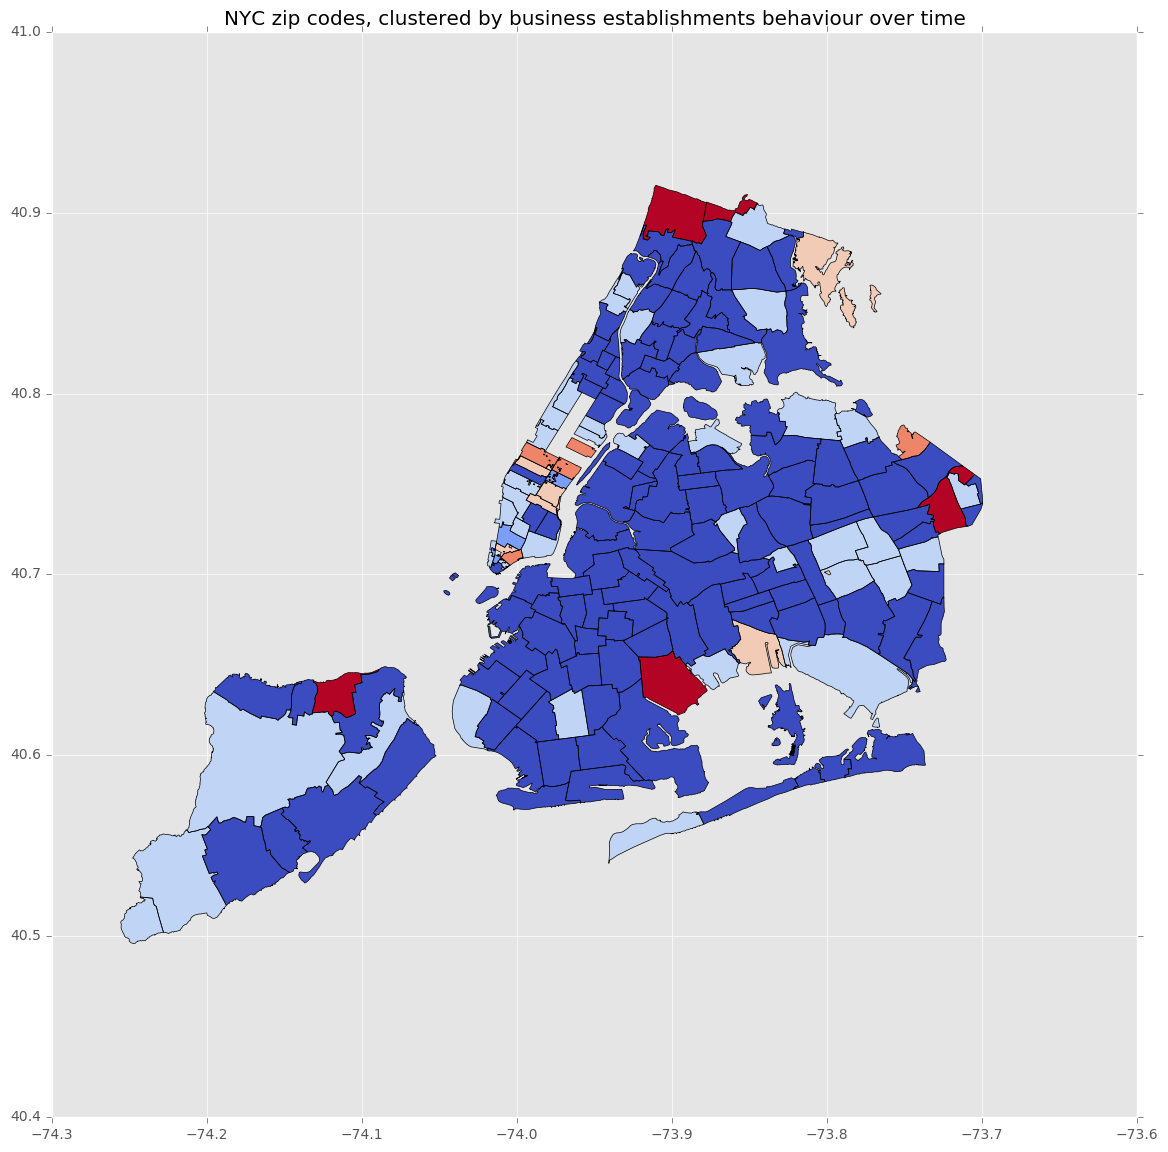

In [312]:
# plot map of NYC zip codes with coloring according to census data clusters
f, ax = plt.subplots(figsize=(14, 14))

nyc_shapes_cluster.plot(
    column='label',
    alpha=1, 
    cmap='coolwarm', 
    linewidth=0.5,
    ax=ax
)
ax.set_title('NYC zip codes, clustered by business establishments behaviour over time')
plt.show()

##### Figure 4: NYC zip codes clustered with k-means, using time series data from 1994 - 2014 of the counts of business establishments within each zone. See interpretation below.

### Interpreting the clustering results at a high level

We used k-means and an agglomerative technique to cluster NYC zip codes based on economic metrics over time; both methods produced extremely similar results.

From Figure 2, we see that 4 out of the 6 clusters are relatively small, extremely flashy/erratic in their behaviour, and even potentially stationary over the long term. The two largest clusters, in the simplest terms, show steady economic growth over time - these are the only clusters that are safely generalizable.  These are shown in dark blue and light blue in Figure 4. By extension, we can make the generalization that the areas that are NOT light/dark blue, have shown less steady growth, if any pattern at all.

It seems reasonable to conclude (and supported by Figure 2 and 4), that both downtown and midtown have been floating around the natural limit for number of establishments for years - that is, those areas are saturated with businesses, and have been for a long time. They don't exhibit the slow growth in business that we see elsewhere.

Unsurprisingly, most of Brooklyn, Queens, the Bronx, and Harlem have seen steady growth in businesses over the last ~20 years.

These are sweeping generalizations, as it is difficult to make decisive conclusions from the results of a clustering analysis.